In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import *
from IPython.display import display, HTML, IFrame
%matplotlib inline
 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png','pdf')


In [4]:
folder = ['compsci-data','jbt-data', 'brands-data-400', 'brands-data-100', 'brands-data-it2', 'jbt-data-it2', 'compsci-data-it2']
MERGE_OTHER = True
ut = 'jbt'
#folder = ['{}-data-it2'.format(ut), '{}-data'.format(ut)]
#folder =['brands-data-400', 'brands-data-100', 'brands-data-it2']
#folder = ['{}-data-it2'.format(ut)]

In [5]:


agg_list = []
full_list = []
test_list = []
for f in folder:
    agg =  pd.read_csv('{}/agg.csv'.format(f))
    agg['type'] = f.split('-')[0]
    agg.set_index('id')
    agg_list.append(agg)
   
    full = pd.read_csv('{}/full.csv'.format(f))
    full['type'] = f.split('-')[0]
    full.set_index('id')
    full_list.append( full)
    test = pd.read_csv('{}/test.csv'.format(f))
    test['type'] = f.split('-')[0]
    test.set_index('id')
    test_list.append (test)
aggregated = pd.concat(agg_list)
if MERGE_OTHER:
    aggregated['label'] = aggregated.apply(lambda row: row['label'] if row['label'] != 'OTHER' else 'NONE', axis=1)
    full['label'] = full.apply(lambda row: row['label'] if row['label'] != 'OTHER' else 'NONE', axis=1)


print(aggregated.describe())
full = pd.concat(full_list)
test_questions = pd.concat(test_list)
aggregated = aggregated[aggregated['_unit_state'] == 'finalized']
aggregated.to_csv('train-data.csv')

def print_info(data):
    avg = pd.merge(data, full, suffixes=['_l', '_r'], on=['id'], how='left')[['id', 'text_readable_r', 'label:confidence', 'label_l', 'label_r', '_trust','a','b']].sort_values(['label:confidence', 'label_l' ,'id'])
    renamed_avg = avg.rename(columns={'label_l' : 'assigned_by_crowdflower', 'label_r' : 'proposed_by_annotator'})
    return renamed_avg


       _trusted_judgments      _unit_id  label:confidence  label_gold
count         4522.000000  4.522000e+03       4522.000000         0.0
mean             3.089783  1.555687e+09          0.879661         NaN
std              0.342244  1.945776e+07          0.179302         NaN
min              1.000000  1.530058e+09          0.333300         NaN
25%              3.000000  1.534177e+09          0.685150         NaN
50%              3.000000  1.557743e+09          1.000000         NaN
75%              3.000000  1.576061e+09          1.000000         NaN
max              6.000000  1.576122e+09          1.000000         NaN


### Quality

In [6]:
conf = aggregated[['id','text_readable', 'label:confidence', 'label']]
display(conf[['label:confidence']].describe())
display(conf[['id', 'text_readable']].describe())

,label:confidence
count,4506.000000
mean,0.879341
std,0.179404
min,0.333300
25%,0.684900
50%,1.000000
75%,1.000000
max,1.000000


,id,text_readable
count,4506,4506
unique,4506,4506
top,G1064241173,"I'm sorry, Sony's going to have to do better o..."
freq,1,1


Sentences with a confidence <= 0.6. Either all three annotators gave a different answer or the annotators are not trustworthy enough.

In [7]:
worst_conf = conf[conf['label:confidence'] <= 0.6]
worst_conf.describe()

,label:confidence
count,191.000000
mean,0.398824
std,0.077695
min,0.333300
25%,0.345300
50%,0.359300
75%,0.474900
max,0.600000


Sentences with 0.60 > confidence < 0.75. Those sentences might introduce noise, but should be useable.

In [8]:
avg_conf = conf[(conf['label:confidence']< 0.75) & (conf['label:confidence']> 0.60)]
avg_conf.describe()

,label:confidence
count,1268.000000
mean,0.671501
std,0.025074
min,0.601300
25%,0.653800
50%,0.669800
75%,0.686100
max,0.749800


Sentences with a confidence greater than 0.75

In [16]:
top_conf = conf[conf['label:confidence'] >= 0.80]
top_conf.describe()

,label:confidence
count,2998.000000
mean,0.999658
std,0.007660
min,0.815500
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


All sentences which should contain enough information to train the system (Confidence >= 66%)

In [8]:
useable = conf[conf['label:confidence'] >= 0.67]
useable.describe()

,label:confidence
count,3680.000000
mean,0.943500
std,0.118528
min,0.670000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


### Hard Sentences

In [17]:
display(print_info(worst_conf.sample(20)).style.background_gradient(cmap=plt.cm.get_cmap('RdYlGn'),subset=['label:confidence']))

,id,text_readable_r,label:confidence,assigned_by_crowdflower,proposed_by_annotator,_trust,a,b
51,S3005172629,"*virginia* Tech put together a solid drive, but §michigan$ forced a 37-yard field goal.",0.3364,WORSE,BETTER,0.9,virginia,michigan
52,S3005172629,"*virginia* Tech put together a solid drive, but §michigan$ forced a 37-yard field goal.",0.3364,WORSE,WORSE,0.9,virginia,michigan
53,S3005172629,"*virginia* Tech put together a solid drive, but §michigan$ forced a 37-yard field goal.",0.3364,WORSE,OTHER,0.875,virginia,michigan
58,G956609037,Holding a *pistol* steady is harder than a §rifle$.,0.3404,NONE,WORSE,0.8621,rifle,pistol
59,G956609037,Holding a *pistol* steady is harder than a §rifle$.,0.3404,NONE,BETTER,0.8333,rifle,pistol
60,G956609037,Holding a *pistol* steady is harder than a §rifle$.,0.3404,NONE,OTHER,0.875,rifle,pistol
26,P2558676297,"The *metal* is a solid quality, and the real wood isnt cheap §plywood$, its very good quality.",0.3408,WORSE,NONE,0.8636,metal,plywood
27,P2558676297,"The *metal* is a solid quality, and the real wood isnt cheap §plywood$, its very good quality.",0.3408,WORSE,WORSE,0.9167,metal,plywood
28,P2558676297,"The *metal* is a solid quality, and the real wood isnt cheap §plywood$, its very good quality.",0.3408,WORSE,BETTER,0.9091,metal,plywood
0,Q2614428771,"The point is Skov saying that somehow *michigan* is worse than a Notre Dame, USC, or §virginia$, because that's just plain false.",0.3452,WORSE,NONE,0.875,virginia,michigan


### Average Sentences

In [18]:
print_info(avg_conf.sample(20)).style.background_gradient(cmap=plt.cm.get_cmap('RdYlGn'),subset=['label:confidence'])

,id,text_readable_r,label:confidence,assigned_by_crowdflower,proposed_by_annotator,_trust,a,b
58,T3177214347,? Why *tennis* is better than §golf$.,0.6362,BETTER,NONE,0.9474,golf,tennis
59,T3177214347,? Why *tennis* is better than §golf$.,0.6362,BETTER,BETTER,0.7857,golf,tennis
60,T3177214347,? Why *tennis* is better than §golf$.,0.6362,BETTER,BETTER,0.871,golf,tennis
3,N2137844702,*Scala* enums are inferior to §Java$ enums _and_ are incompatible.,0.6364,WORSE,WORSE,0.9167,Java,Scala
4,N2137844702,*Scala* enums are inferior to §Java$ enums _and_ are incompatible.,0.6364,WORSE,WORSE,0.8333,Java,Scala
5,N2137844702,*Scala* enums are inferior to §Java$ enums _and_ are incompatible.,0.6364,WORSE,BETTER,1,Java,Scala
12,C384502470,"*Asus* or §Gigabyte$ 1366, X58 compatible motherboard.",0.6409,NONE,NONE,0.8636,Gigabyte,Asus
13,C384502470,"*Asus* or §Gigabyte$ 1366, X58 compatible motherboard.",0.6409,NONE,OTHER,0.8947,Gigabyte,Asus
14,C384502470,"*Asus* or §Gigabyte$ 1366, X58 compatible motherboard.",0.6409,NONE,NONE,0.7333,Gigabyte,Asus
0,H1143026395,"I have also rented many cars, American and Japanese, and with the exception of a very smooth ride in a Cadillac, I always like the Japanese cars better (Nissan and *Toyota*, vs. Ford, §Chrysler$ and GM).",0.6576,BETTER,BETTER,0.8125,Toyota,Chrysler


### Easy Sentences

In [20]:
print_info(top_conf.sample(20)).style.background_gradient(cmap=plt.cm.get_cmap('RdYlGn_r'),subset=['label:confidence'])

,id,text_readable_r,label:confidence,assigned_by_crowdflower,proposed_by_annotator,_trust,a,b
25,B201165565,"All said, I feel Honda and *Toyota* are considerably more reliable and just better overall cars than §Nissan$.",1,BETTER,BETTER,0.8667,Toyota,Nissan
26,B201165565,"All said, I feel Honda and *Toyota* are considerably more reliable and just better overall cars than §Nissan$.",1,BETTER,BETTER,0.75,Toyota,Nissan
27,B201165565,"All said, I feel Honda and *Toyota* are considerably more reliable and just better overall cars than §Nissan$.",1,BETTER,BETTER,0.913,Toyota,Nissan
6,E614184218,"Drivetrain Due to its much higher torque, the engine of the *Chrysler* 200 does a much better job of transmitting power to the wheels than the §Toyota$ Corolla.",1,BETTER,BETTER,0.8696,Toyota,Chrysler
7,E614184218,"Drivetrain Due to its much higher torque, the engine of the *Chrysler* 200 does a much better job of transmitting power to the wheels than the §Toyota$ Corolla.",1,BETTER,BETTER,0.8667,Toyota,Chrysler
8,E614184218,"Drivetrain Due to its much higher torque, the engine of the *Chrysler* 200 does a much better job of transmitting power to the wheels than the §Toyota$ Corolla.",1,BETTER,BETTER,0.8,Toyota,Chrysler
51,E704066745,"*Ferrari* was still leading the constructors' championship, but only by 3 points to §BMW$ Sauber.",1,BETTER,BETTER,0.8571,Ferrari,BMW
52,E704066745,"*Ferrari* was still leading the constructors' championship, but only by 3 points to §BMW$ Sauber.",1,BETTER,BETTER,0.8529,Ferrari,BMW
53,E704066745,"*Ferrari* was still leading the constructors' championship, but only by 3 points to §BMW$ Sauber.",1,BETTER,BETTER,0.9091,Ferrari,BMW
3,H1087976118,I found the JS and *PHP* lib easier to work with than the §Java$ ones.,1,BETTER,BETTER,0.9583,Java,PHP


### All Sentences

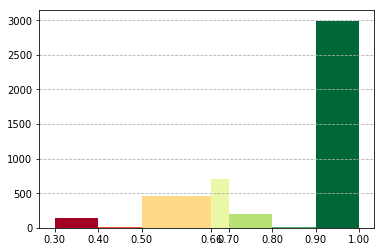

In [12]:
color_map = plt.cm.get_cmap('RdYlGn')
#plt.title('Confidence of Labeling')
plt.grid(axis='y', linestyle='dashed')
ticks = [0.3, 0.4, 0.5, 0.66, 0.7, 0.8, 0.9, 1]
plt.xticks(ticks)
n, bins, patches = plt.hist(
    aggregated['label:confidence'], bins=ticks, color='green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', color_map(c))
plt.show()

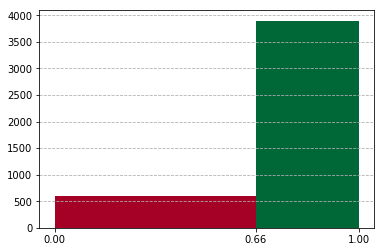

In [13]:
color_map = plt.cm.get_cmap('RdYlGn')
#plt.title('Confidence of Labeling')
plt.grid(axis='y', linestyle='dashed')
ticks = [0.0,  0.66, 1]
plt.xticks(ticks)
n, bins, patches = plt.hist(
    aggregated['label:confidence'], bins=ticks, color='green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', color_map(c))
plt.show()

## Results

**Label Distribution**

In [14]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

def show_dist(labels):

    plt.figure(figsize=plt.figaspect(1))
    plt.pie(
        labels.value_counts().values,
        labels=labels.value_counts().keys().tolist(),
        radius=2,
        autopct=make_autopct(labels.value_counts().values))
    plt.show()


**All sentences**

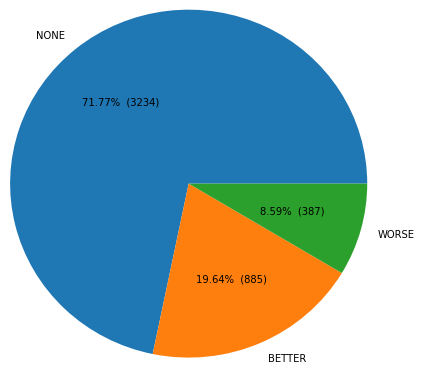

In [15]:
show_dist(aggregated['label'])

**Sentences with conf >= 66**

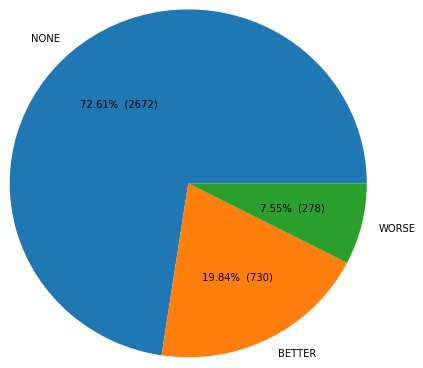

In [16]:
show_dist(useable['label'])